In [2]:
!pip install networkx

     |████████████████████████████████| 2.0 MB 7.0 MB/s eta 0:00:01


In [41]:
import networkx as nx
import matplotlib.pyplot as plt

In [42]:
G = nx.DiGraph()

In [43]:
G.add_nodes_from([0, 1, 2, 3])

In [44]:
G.__dict__

{'graph': {},
 '_node': {0: {}, 1: {}, 2: {}, 3: {}},
 '_adj': {0: {}, 1: {}, 2: {}, 3: {}},
 '_succ': {0: {}, 1: {}, 2: {}, 3: {}},
 '_pred': {0: {}, 1: {}, 2: {}, 3: {}}}

In [148]:
G.add_edges_from([
    (0, 1, {"cost": lambda x: x}), 
    (0, 2, {"cost": lambda x: 100}),
    (1, 2, {"cost": lambda x: 0}),
    (1, 3, {"cost": lambda x: 100}),
    (2, 3, {"cost": lambda x: x})])

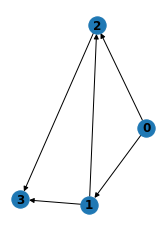

In [149]:
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')

In [150]:
for node in G.nodes:
    d = G.adj[node]
    action_map = {i: n for i,n in enumerate(d)}
    G.nodes[node]["action_map"] = action_map

In [151]:
G.nodes

NodeView((0, 1, 2, 3))

In [163]:
G.edges(0)

OutEdgeDataView([(0, 1), (0, 2)])

In [153]:
G.adj

AdjacencyView({0: {1: {'cost': <function <lambda> at 0x7fe831512550>}, 2: {'cost': <function <lambda> at 0x7fe831512160>}}, 1: {2: {'cost': <function <lambda> at 0x7fe831512430>}, 3: {'cost': <function <lambda> at 0x7fe8315124c0>}}, 2: {3: {'cost': <function <lambda> at 0x7fe8315120d0>}}, 3: {}})

In [154]:
G.degree

DiDegreeView({0: 2, 1: 3, 2: 3, 3: 2})

In [155]:
G[0][1]["cost"](0.5)

0.5

In [156]:
n_agents = 100
n_actions = 2
n_states = 4

In [157]:
G.nodes[0]["vehicles"] = 100

In [454]:
from agent_functions import bellman_update_q_table, e_greedy_select_action
import numpy as np

In [534]:
Q = - np.random.random_sample(size=(n_agents, n_states, n_actions)) - 1

In [535]:
T = np.zeros(n_agents)

In [536]:
S = np.zeros((n_agents)).astype(int)

In [537]:
remaining_agents = np.where(S!=3, True, False)
fastest = np.where(T == T.min(), True, False)
agents = fastest * remaining_agents
states = S[agents]
agents, states

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [538]:
A = e_greedy_select_action(Q[agents], states, 0.1)
A

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [539]:
uni = np.unique(states)
R = np.zeros(len(A))
for s in uni:
    if s == 3:
        # terminate
        pass
    else:
        print(s)
        edges = [neighbour[1] for neighbour in G.edges(s)]
        print(edges)
        agents_at_s = np.where(states==s, True, False) 
        print(agents_at_s)
        actions = np.clip(A[agents_at_s].flatten(), 0, len(edges)-1)
        print(actions)
        counts = np.bincount(actions, minlength=n_actions)
        print(counts)
        rewards = [G.adj[s][neighbour[1]]["cost"](counts[i]) for i,neighbour in enumerate(G.edges(s))]
        print(rewards)
        R[agents_at_s] = np.array([rewards[a] for a in actions])
        print(R[agents_at_s])
        states[agents_at_s] = np.array([edges[a] for a in actions]).astype(int)
        print(states[agents_at_s])
S[agents] = states

0
[1, 2]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1
 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0
 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1]
[39 61]
[39, 100]
[100.  39. 100. 100. 100.  39.  39.  39. 100. 100. 100. 100.  39. 100.
  39. 100.  39. 100.  39.  39. 100. 100. 100.  39. 100. 100. 100.  39.
 100. 100. 100. 1

In [540]:
T[agents] += R

In [541]:
Q[agents], _ = bellman_update_q_table(Q[agents], states, A, R, 0.1, 0.2)

In [542]:
T

array([100.,  39., 100., 100., 100.,  39.,  39.,  39., 100., 100., 100.,
       100.,  39., 100.,  39., 100.,  39., 100.,  39.,  39., 100., 100.,
       100.,  39., 100., 100., 100.,  39., 100., 100., 100., 100.,  39.,
       100., 100.,  39., 100.,  39.,  39., 100.,  39.,  39.,  39., 100.,
        39., 100., 100.,  39., 100., 100., 100.,  39., 100., 100.,  39.,
       100., 100., 100., 100., 100.,  39.,  39.,  39.,  39.,  39., 100.,
       100.,  39., 100.,  39., 100., 100., 100.,  39.,  39.,  39., 100.,
        39., 100., 100., 100., 100.,  39., 100., 100.,  39.,  39., 100.,
       100.,  39., 100., 100.,  39., 100., 100., 100., 100.,  39., 100.,
       100.])

In [543]:
S

array([2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2,
       1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
       2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2])

In [544]:
R

array([100.,  39., 100., 100., 100.,  39.,  39.,  39., 100., 100., 100.,
       100.,  39., 100.,  39., 100.,  39., 100.,  39.,  39., 100., 100.,
       100.,  39., 100., 100., 100.,  39., 100., 100., 100., 100.,  39.,
       100., 100.,  39., 100.,  39.,  39., 100.,  39.,  39.,  39., 100.,
        39., 100., 100.,  39., 100., 100., 100.,  39., 100., 100.,  39.,
       100., 100., 100., 100., 100.,  39.,  39.,  39.,  39.,  39., 100.,
       100.,  39., 100.,  39., 100., 100., 100.,  39.,  39.,  39., 100.,
        39., 100., 100., 100., 100.,  39., 100., 100.,  39.,  39., 100.,
       100.,  39., 100., 100.,  39., 100., 100., 100., 100.,  39., 100.,
       100.])

In [545]:
G.edges(1)

OutEdgeDataView([(1, 2), (1, 3)])

In [373]:
np.unique(S)

array([1, 2])

In [194]:
np.where(S==0, True, False)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [165]:
G.adj[s][1]["cost"](counts[0])

55

In [169]:
R

array([100., 100.,  55., 100.,  55.,  55., 100.,  55.,  55.,  55.,  55.,
        55.,  55.,  55.,  55.,  55.,  55., 100., 100.,  55.,  55.,  55.,
        55., 100.,  55.,  55., 100.,  55.,  55.,  55.,  55.,  55.,  55.,
        55.,  55.,  55., 100., 100.,  55., 100., 100., 100.,  55., 100.,
       100., 100., 100.,  55., 100., 100., 100.,  55., 100., 100., 100.,
        55.,  55., 100.,  55., 100.,  55., 100., 100., 100., 100., 100.,
        55., 100.,  55., 100.,  55.,  55.,  55., 100., 100., 100.,  55.,
        55., 100.,  55.,  55.,  55.,  55., 100.,  55., 100., 100., 100.,
       100.,  55., 100., 100., 100.,  55., 100.,  55.,  55.,  55.,  55.,
        55.])

In [ ]:
remaining_agents = np.where(S!=3, True, False)
fastest = np.where(T == T.min(), True, False)
agents = fastest * remaining_agents
states = S[agents]
A = e_greedy_select_action(Q[agents], states, 0.1)

In [520]:
def async_braess(graph, states, A):
    uni = np.unique(states)
    R = np.zeros(len(A))
    for s in uni:
        if s == 3:
            # terminate
            pass
        else:
            edges = [neighbour[1] for neighbour in graph.edges(s)]
            agents_at_s = np.where(states==s, True, False) 
            actions = np.clip(A[agents_at_s].flatten(), 0, len(edges)-1)
            counts = np.bincount(actions, minlength=n_actions)
            rewards = [graph.adj[s][neighbour[1]]["cost"](counts[i]) for i,neighbour in enumerate(graph.edges(s))]
            R[agents_at_s] = np.array([rewards[a] for a in actions])
            states[agents_at_s] = np.array([edges[a] for a in actions]).astype(int)
    
    return states, R

In [513]:
S[agents] = states    
T[agents] += R
Q[agents], _ = bellman_update_q_table(Q[agents], states, A, R, 0.1, 0.2)

IndentationError: unexpected indent (3437674642.py, line 3)

In [564]:
from run_functions import *
import copy

In [592]:
n_agents = 100
n_actions = 2
n_states = 4
n_iter = 1000

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([
    (0, 1, {"cost": lambda x: x}), 
    (0, 2, {"cost": lambda x: 100}),
    (1, 2, {"cost": lambda x: 0}),
    (1, 3, {"cost": lambda x: 100}),
    (2, 3, {"cost": lambda x: x})])
# for node in G.nodes:
#     d = G.adj[node]
#     action_map = {i: n for i,n in enumerate(d)}
#     G.nodes[node]["action_map"] = action_map

In [602]:
# Q = initialize_q_table("UNIFORM", n_agents, n_states, n_actions)
Q = - np.random.random_sample(size=(n_agents, n_states, n_actions))*100 - 100
alpha = initialize_learning_rates(0.1, n_agents)
epsilon = initialize_exploration_rates(0.1, n_agents)
data = {}
ind = np.arange(n_agents)

for t in range(n_iter):
    T = np.zeros(n_agents)
    S = np.zeros(n_agents).astype(int)
    
    while np.where(S==3, False, True).sum() > 0:
        remaining_agents = np.where(S!=3, True, False)
        agents = np.where(T == T[remaining_agents].min(), True, False)
        states = S[agents]
        A = e_greedy_select_action(Q[agents], states, 0.1)

        uni = np.unique(states)
        R = np.zeros(len(A))
        for s in uni:
            if s == 3:
                # terminate
                pass
            else:
                edges = [neighbour[1] for neighbour in G.edges(s)]
                agents_at_s = np.where(states==s, True, False) 
                actions = np.clip(A[agents_at_s].flatten(), 0, len(edges)-1)
                counts = np.bincount(actions, minlength=n_actions)
                rewards = [G.adj[s][neighbour[1]]["cost"](counts[i]) for i,neighbour in enumerate(G.edges(s))]
                R[agents_at_s] = np.array([rewards[a] for a in actions])
                states[agents_at_s] = np.array([edges[a] for a in actions]).astype(int)
                Q[agents][agents_at_s], _ = bellman_update_q_table(Q[agents][agents_at_s], states[agents_at_s], A[agents_at_s], -R[agents_at_s], 0.1, 0.2)
                
        S[agents] = states    
        T[agents] += R

    ## SAVE PROGRESS DATA
    data[t] = {
               "T": T,
               "S": S,
               "Q": copy.deepcopy(Q),
               "amax": Q[:,0].mean(axis=0).argmax()
               }

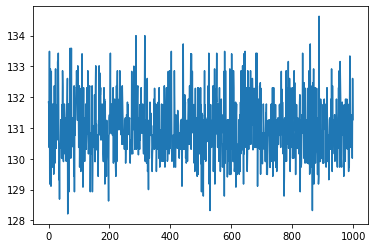

In [597]:
plt.plot([data[i]["T"].mean() for i in data.keys()])

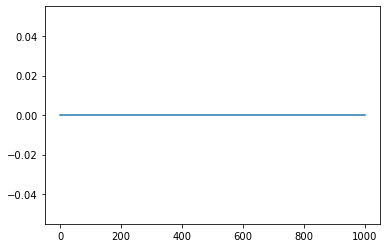

In [603]:
plt.plot([data[i]["amax"].mean() for i in data.keys()])

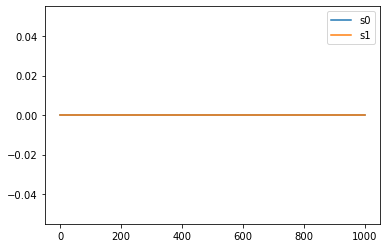

In [598]:
plt.plot([data[i]["Q"][:,0].mean(axis=0).argmax() for i in data.keys()], label="s0")
plt.plot([data[i]["Q"][:,1].mean(axis=0).argmax() for i in data.keys()], label="s1")
plt.legend()

In [601]:
[data[i]["Q"][99][1] for i in data.keys()]

[array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
 array([-101.6839642 , -122.44606221]),
